This is just for starting the python script. No need to include it in the code

In [1]:
# Import the modules and packages we will use
import json
import os
from datetime import datetime
from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import patsy

%load_ext blackcellmagic


plt.style.use(['science', 'nature'])
dotenv.load_dotenv()
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [37]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Here we are configuring the script

In [3]:
# Define GLOBAL variables

# Set the airport of interest to ORD (O'Hare International Airport)
AIRPORT_OF_INTEREST = "ORD"

#### PATHS AND DIRECTORIES
ROOT = Path(".")  # root path (the directory of the project folder)

# Where to store the input data
DATA_FOLDER = "data"
RAW_DATA_FOLDER = "raw"
RAW_FLIGHTS_DATA_FOLDER = "flights"
PROCESSED_DATA_FOLDER = "processed"
OUTPUT_DATA_FOLDER = "output"

DATA_PATH = ROOT / DATA_FOLDER

if not Path.exists(DATA_PATH):
    raise FileNotFoundError(f"The data folder does not exist: {DATA_PATH}")

RAW_DATA_PATH = DATA_PATH / RAW_DATA_FOLDER

if not Path.exists(RAW_DATA_PATH):
    raise FileNotFoundError(f"The raw data folder does not exist: {RAW_DATA_PATH}")

RAW_FLIGHTS_DATA_PATH = DATA_PATH / RAW_DATA_FOLDER / RAW_FLIGHTS_DATA_FOLDER

if not Path.exists(RAW_FLIGHTS_DATA_PATH):
    raise FileNotFoundError(
        f"The raw flights data folder does not exist: {RAW_FLIGHT_DATA_PATH}"
    )

PROCESSED_DATA_PATH = DATA_PATH / PROCESSED_DATA_FOLDER
Path.mkdir(PROCESSED_DATA_PATH, parents=True, exist_ok=True)

OUTPUT_DATA_PATH = DATA_PATH / OUTPUT_DATA_FOLDER
Path.mkdir(OUTPUT_DATA_PATH, parents=True, exist_ok=True)

# Name of the HDF5 file containing the data
HDF5_FILE = "flight_data.h5"

# Name of the CSV file containing the airport codes
AIRPORT_CODES_FILE = "airport_codes.csv"

# Name of the JSON file containing the weather daata
WEATHER_FILE = "ORD-weather-2009-2018.json"

##  1. Process the flight data

The data we downloaded from [“Airline Delay and Cancellation Data 2009 - 2018” Kaggle dataset](https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018). It is in the folder `data/raw/flights` separated by year. It includes all the flights.

We need only the flights departing from Chicago Ohare (ORD), so we join (concatenate) all the csv folders into one big dataframe, and then filter the dataframe to only include flights departing from Chicago Ohare (ORD).

In [4]:
def process_flight_data(
    raw_flights_data_path: Path = RAW_FLIGHTS_DATA_PATH,
    processed_data_path: Path = PROCESSED_DATA_PATH,
    hdf5_file: str = HDF5_FILE, key=f"ORIGIN:{AIRPORT_OF_INTEREST}"
):
    
    def load_csv_files(files: list) -> pd.DataFrame:
        li = []  # where to store each csv file as a dataframe
        for filename in csv_files.__iter__():
            df = pd.read_csv(filename, index_col=None, header=0)
            li.append(df)
        return pd.concat(li, axis=0, ignore_index=True)

    # Try to load the HDF5 file
    try:
        df = pd.read_hdf(processed_data_path / hdf5_file, key=key)
    except (FileNotFoundError, KeyError): # if it does not exist, or key is wrong, create it
        # Get all the CSV Files
        csv_files = sorted(raw_flights_data_path.glob("*.csv"))
        
        print(f"Loading files, this may take a while...")
        df = load_csv_files(csv_files)
        
        # filter the dataframe
        df = df[df["ORIGIN"] == AIRPORT_OF_INTEREST]
        # save dataframe to HDF5 file
        df.to_hdf(processed_data_path / hdf5_file, key=key, mode="w", index=False)
    
    return df.reset_index(drop=True) # return the dataframe

df_flights = process_flight_data()

print("Dataframe loaded and filtered, lets look at the first rows to understand what we are doing")
df_flights.head()

Dataframe loaded and filtered, lets look at the first rows to understand what we are doing


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,XE,1232,ORD,EWR,905.0,900.0,-5.0,16.0,916.0,...,127.0,110.0,88.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,XE,1234,ORD,EWR,1230.0,1234.0,4.0,8.0,1242.0,...,149.0,111.0,89.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01,XE,1236,ORD,EWR,1630.0,1619.0,-11.0,19.0,1638.0,...,152.0,142.0,88.0,719.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01,XE,2647,ORD,IAH,1205.0,1154.0,-11.0,15.0,1209.0,...,180.0,163.0,142.0,925.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,XE,2865,ORD,IAH,1500.0,1453.0,-7.0,11.0,1504.0,...,174.0,159.0,136.0,925.0,NaN,NaN,NaN,NaN,NaN,NaN


Let's look at the data columns we have

In [5]:
df_flights.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

in prettier format:

|         Name        |                                                 Description                                                |   Type(Format)  |   Example  |
|:-------------------:|:----------------------------------------------------------------------------------------------------------:|:---------------:|:----------:|
|       FL_DATE       |                                             Date of the flight                                             | DATE (yy/mm/dd) | 2009-05-02 |
|      OP_CARRIER     |                                             Airline Identifier                                             |      STRING     |     9E     |
|  OP_CARRIER_FL_NUM  |                                                Flight Number                                               |     INTEGER     |    2216    |
|        ORIGIN       |                                      Starting Airport Code (IATA Code)                                     |      STRING     |     MLI    |
|         DEST        |                                    Destination Airport Code (IATA Code)                                    |      STRING     |     MEM    |
|     CRS_DEP_TIME    |                                           Planned Departure Time                                           |     INTEGER     |     600    |
|       DEP_TIME      |                                            Actual Departure Time                                           |      FLOAT      |    603.0   |
|      DEP_DELAY      |                                     Total Delay on Departure in minutes                                    |      FLOAT      |     3.0    |
|       TAXI_OUT      |           The time duration elapsed between departure from the origin airport gate and wheels off          |      FLOAT      |    14.0    |
|      WHEELS_OFF     |                         The time point that the aircraft’s wheels leave the ground                         |      FLOAT      |    617.0   |
|      WHEELS_ON      |                        The time point that the aircraft’s wheels touch on the ground                       |      FLOAT      |    757.0   |
|       TAXI_IN       |           The time duration elapsed between wheels-on and gate arrival at the destination airport          |      FLOAT      |     8.0    |
|     CRS_ARR_TIME    |                                            Planned arrival time                                            |     INTEGER     |     732    |
|       ARR_TIME      |                                             Actual Arrival Time                                            |      FLOAT      |    805.0   |
|      ARR_DELAY      |                                      Total Delay on Arrival in minutes                                     |      FLOAT      |    33.0    |
|      CANCELLED      |                                      Flight Cancelled (1 = cancelled)                                      |      FLOAT      |     0.0    |

In [6]:
printmd(f"## Size of the data: {df_flights.shape}")

## Size of the data: (3001285, 28)

## We need to get the weather data

[The data comes from VisualCrossing](https://visualcrossing.com/account).We have a file in `data/raw/` called `ORD-weather-2009-2018.json` which contains the weather data for Chicago Ohare (ORD) for all the years 2009-2018.

In [7]:
def process_weather_data(
    raw_weather_data: Path = RAW_DATA_PATH / WEATHER_FILE,
    processed_data_path: Path = PROCESSED_DATA_PATH,
    hdf5_file: str = "ord_weather.h5",
    key=f"WEATHER:{AIRPORT_OF_INTEREST}",
):
    def load_json_file(files: list) -> pd.DataFrame:
        data = json.load(open(raw_weather_data))

        li = []  # where to store each csv file as a dataframe

        for day in data["days"]:
            df = pd.DataFrame(day["hours"])
            # do some transformations
            df.rename(
                columns={"datetime": "time", "datetimeEpoch": "date"}, inplace=True
            )

            df["date"] = df["date"].apply(
                lambda x: (pd.to_datetime(datetime.fromtimestamp(x)))
            )
            df["date"] = df["date"].dt.date
            li.append(df)

        return pd.concat(li, axis=0, ignore_index=True)

    # Try to load the HDF5 file
    try:
        df = pd.read_hdf(processed_data_path / hdf5_file, key=key)
    except (
        FileNotFoundError,
        KeyError,
    ):  # if it does not exist, or key is wrong, create it
        # Get all the CSV Files

        print(f"Loading files, this may take a while...")
        df = load_json_file(RAW_DATA_PATH / WEATHER_FILE)

        # save dataframe to HDF5 file
        df.to_hdf(processed_data_path / hdf5_file, key=key, mode="w", index=False)

    return df  # return the dataframe


df_weather = process_weather_data()

Lets look at how the data looks

In [8]:
df_weather.head()

,time,date,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,...,visibility,cloudcover,solarradiation,solarenergy,uvindex,conditions,icon,stations,source,tzoffset
0,00:00:00,2009-01-01,-8.3,-13.6,66.89,-13.4,0.0,None,None,None,...,16.0,88.0,None,None,0.0,Partially cloudy,partly-cloudy-night,"[72534014819, 72530094846, 74466504838]",obs,NaN
1,01:00:00,2009-01-01,-8.2,-14.7,66.58,-13.4,0.0,None,None,None,...,16.0,88.0,None,None,0.0,Partially cloudy,partly-cloudy-night,"[72534014819, 72530094846, 74466504838]",obs,NaN
2,02:00:00,2009-01-01,-7.8,-14.6,66.38,-13.0,0.0,None,None,None,...,16.0,91.6,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN
3,03:00:00,2009-01-01,-7.1,-14.3,67.03,-12.2,0.0,None,None,None,...,16.0,100.0,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN
4,04:00:00,2009-01-01,-7.1,-13.9,69.46,-11.8,0.0,None,None,None,...,16.0,100.0,None,None,0.0,Overcast,cloudy,"[72534014819, 72530094846, 74466504838]",obs,NaN


This are the columns of data we have

In [9]:
df_weather.columns

Index(['time', 'date', 'temp', 'feelslike', 'humidity', 'dew', 'precip',
       'precipprob', 'snow', 'snowdepth', 'preciptype', 'windgust',
       'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover',
       'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon',
       'stations', 'source', 'tzoffset'],
      dtype='object')

A summary of the data

In [10]:
df_weather.describe()

,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover,uvindex,tzoffset
count,87648.000000,87648.000000,87648.000000,87648.000000,87641.000000,87648.000000,87310.000000,87647.000000,87648.000000,87648.000000,87648.0,57110.0
mean,10.600452,8.706654,67.513745,4.273025,0.114299,15.209802,187.244348,1016.451836,14.617897,65.547010,0.0,-5.0
std,11.541020,13.909802,16.995718,10.723695,0.837129,8.406331,108.078392,7.525111,3.335163,35.153918,0.0,0.0
min,-27.100000,-41.000000,13.610000,-32.800000,0.000000,0.000000,0.000000,979.500000,0.000000,0.000000,0.0,-5.0
25%,1.700000,-2.100000,55.520000,-3.200000,0.000000,9.300000,83.000000,1011.800000,15.800000,28.400000,0.0,-5.0
50%,11.000000,11.000000,68.820000,4.500000,0.000000,14.400000,203.000000,1016.300000,16.000000,81.800000,0.0,-5.0
75%,20.100000,20.100000,80.830000,13.100000,0.000000,20.400000,278.000000,1021.100000,16.000000,99.400000,0.0,-5.0
max,39.100000,43.300000,100.000000,26.000000,72.830000,64.800000,360.000000,1043.900000,17.900000,100.000000,0.0,-5.0


## Now we need to merge the data.

But first we need to process the flights df and weather df to match the time and dates when joining

In [11]:
df_flights.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

Looking at the data, the time columns on `df_flighs` like `CRS_DEP_TIME` and `DEP_TIME` are in the complete time format HHMM, while the weather data has one datapoint at each hour HH:00. What we are going to do is create new columns rounding up the time columns on `df_flights` to the floor hour (trim hour) and then merge the two dataframes.

The modified time columns will have the suffix `_hour`

`df_flights`

In [12]:
df_flight_time_cols = ["CRS_DEP_TIME", "DEP_TIME", "CRS_ARR_TIME", "ARR_TIME"]

for col in df_flight_time_cols:
    print("Working on column:", col)
    df_flights[col] = df_flights[col].fillna(0)
    col_and_suffix = col + "_hour"
    df_flights[col_and_suffix] = (df_flights[col] / 100).astype(int)


# duplicate some columns and rename to match the weather df
df_flights["date"] = pd.to_datetime(df_flights["FL_DATE"]).dt.date
df_flights["time_hour"] = df_flights.CRS_DEP_TIME_hour

Working on column: CRS_DEP_TIME
Working on column: DEP_TIME
Working on column: CRS_ARR_TIME
Working on column: ARR_TIME


`df_weather`

In [13]:
df_weather['time_hour'] = pd.to_datetime(df_weather['time']).dt.strftime('%H').astype(int)

Merge the dataframes

In [14]:
df = pd.merge(df_flights, df_weather, on=['date', 'time_hour'])

Let's look at the columns

In [15]:
df.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27', 'CRS_DEP_TIME_hour', 'DEP_TIME_hour',
       'CRS_ARR_TIME_hour', 'ARR_TIME_hour', 'date', 'time_hour', 'time',
       'temp', 'feelslike', 'humidity', 'dew', 'precip', 'precipprob', 'snow',
       'snowdepth', 'preciptype', 'windgust', 'windspeed', 'winddir',
       'pressure', 'visibility', 'cloudcover', 'solarradiation', 'solarenergy',
       'uvindex', 'conditions', 'icon', 'stations', 'source', 'tzoffset'],
      dtype='object')

So there's a few columns that we don't need or are duplicated.

The ones we need to remove are:
- `FL_DATE` - we already have `date` column
- `ORIGIN` - they all are coming out of ORD
- `WHEELS_ON`, `WHEELS_OFF`, `TAXI_IN`, `CRS_ARR_TIME`, `ARR_TIME`, `ARR_DELAY` - this happen after the even of delay
- The types of delay: `SECURITY_DELAY`, etc...
- `Unnamed: 27`, `ACTUAL_ELAPSED_TIME`, `AIR_TIME`, `DISTANCE`, `CRS_ARR_TIME_hour`, `ARR_TIME_hour`, `CANCELLATION_CODE`, `DIVERTED`, `CRS_ELAPSED_TIME` - there are not useful or we already discarded them
- `solarradiation`, `solarenergy`, `uvindex`, `icon`, `stations`, `source`, `conditions`, `tzoffset`
- `precipprob`, `snow`, `snowdepth`, `preciptype`, `windgust` -> this have little data

In [16]:
df_cleaned = df.copy(deep=True)
df_cleaned = df_cleaned.drop(
    [
        "FL_DATE",
        "ORIGIN",
        "WHEELS_ON",
        "WHEELS_OFF",
        "TAXI_IN",
        "TAXI_OUT",
        "CARRIER_DELAY",
        "CANCELLATION_CODE",
        "CRS_ARR_TIME",
        "ARR_TIME",
        "ARR_DELAY",
        "SECURITY_DELAY",
        "CRS_ELAPSED_TIME",
        "WEATHER_DELAY",
        "NAS_DELAY",
        "LATE_AIRCRAFT_DELAY",
        "Unnamed: 27",
        "ACTUAL_ELAPSED_TIME",
        "AIR_TIME",
        "DISTANCE",
        "CRS_ARR_TIME_hour",
        "DIVERTED",
        "ARR_TIME_hour",
        "solarradiation",
        "solarenergy",
        "uvindex",
        "icon",
        "stations",
        "source",
        "conditions",
        "tzoffset",
        "precipprob",
        "snow",
        "snowdepth",
        "preciptype",
        "windgust",
        "OP_CARRIER_FL_NUM"
    ],
    axis=1,
)

del df, df_flights, df_weather  # delete the dataframes to free up memory

df_cleaned.head()

,OP_CARRIER,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CANCELLED,CRS_DEP_TIME_hour,DEP_TIME_hour,date,time_hour,...,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover
0,XE,EWR,905.0,900.0,-5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
1,YV,CHS,910.0,905.0,-5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
2,YV,COS,941.0,939.0,-2.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
3,YV,ORF,920.0,925.0,5.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
4,OH,CVG,925.0,925.0,0.0,0.0,9,9,2009-01-01,9,...,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2


- Create a column `DELAYED` if delay is greater than 0
- Create a column `DELAYED_20` if delay is greater than 20


In [17]:
df_cleaned['DELAYED'] = (df_cleaned['DEP_DELAY'] > 0).astype(int)
df_cleaned['DELAYED_20'] = (df_cleaned['DEP_DELAY'] >= 20).astype(int)

rearrange the columns. Remove `DEP_TIME` because we already have `DELAYED` and `DELAYED_20`

In [18]:
df_cleaned.columns

df_cleaned = df_cleaned[
    [
        "CANCELLED",
        "DELAYED",
        "DELAYED_20",
        "DEP_DELAY",
        "CRS_DEP_TIME",
        "date",
        "time",
        "OP_CARRIER",
        "DEST",        
        "temp",
        "feelslike",
        "humidity",
        "dew",
        "precip",
        "windspeed",
        "winddir",
        "pressure",
        "visibility",
        "cloudcover",
    ]
]


# modify the type of cancelled
df_cleaned.CANCELLED = df_cleaned.CANCELLED.astype(int)

df_cleaned.head()

,CANCELLED,DELAYED,DELAYED_20,DEP_DELAY,CRS_DEP_TIME,date,time,OP_CARRIER,DEST,temp,feelslike,humidity,dew,precip,windspeed,winddir,pressure,visibility,cloudcover
0,0,0,0,-5.0,905.0,2009-01-01,09:00:00,XE,EWR,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
1,0,0,0,-5.0,910.0,2009-01-01,09:00:00,YV,CHS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
2,0,0,0,-2.0,941.0,2009-01-01,09:00:00,YV,COS,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
3,0,1,0,5.0,920.0,2009-01-01,09:00:00,YV,ORF,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2
4,0,0,0,0.0,925.0,2009-01-01,09:00:00,OH,CVG,-5.6,-13.4,67.83,-10.6,0.0,26.9,188.0,1020.8,16.0,87.2


for the date, add a column `day`, `month`, `weekday`, `quarter`, `is_holiday`, `is_weekend`

In [19]:
# set up type
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

# set up for holiday calendar
cal = calendar()
holidays = cal.holidays(start=df_cleaned['date'].min(), end=df_cleaned['date'].max())


df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['weekday'] = df_cleaned['date'].dt.dayofweek + 1
df_cleaned['quarter'] = df_cleaned['date'].dt.quarter
df_cleaned['is_holiday'] = df_cleaned['date'].isin(holidays).astype(int)
df_cleaned['is_weekend'] = (df_cleaned['weekday'] > 5).astype(int)

### theres a few outliers precip so lets remove them

In [20]:

df_cleaned = df_cleaned[df_cleaned.precip < 30]

Finally, drop the date and time column


In [21]:
df_cleaned.drop(['date', 'time'], axis=1, inplace=True)

# FINALLY we can start the analysis

## Remember, we are focusing on prediction, not on inference on this analysis

### I'm also saving a sample of the dataframe as an excel file so you can open it in case you have any issues

In [22]:
df_cleaned.sample(10000).to_excel(OUTPUT_DATA_PATH / 'cleaned_data.xlsx', index=False)

We will standardize the columns in the form z = (x - mean) / std
The columns will be `temp`, `feelslike`, `dewpoint`, `windspeed`, `visibility`, `pressure`, `cloudcover`, `humidity`, `precipitation`, `winddir`


In [23]:
from sklearn import preprocessing

df_norm = df_cleaned.copy(deep=True)
def normalize_colum(df, col):
    x = df[col].values #returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x = x.reshape(-1, 1)
    x_scaled = min_max_scaler.fit_transform(x)
    return x_scaled

for col in ['temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover']:
    df_norm[col] = normalize_colum(df_norm, col)

In [24]:
df_norm.head()

,CANCELLED,DELAYED,DELAYED_20,DEP_DELAY,CRS_DEP_TIME,OP_CARRIER,DEST,temp,feelslike,humidity,...,windspeed,winddir,pressure,visibility,cloudcover,month,weekday,quarter,is_holiday,is_weekend
0,0,0,0,-5.0,905.0,XE,EWR,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
1,0,0,0,-5.0,910.0,YV,CHS,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
2,0,0,0,-2.0,941.0,YV,COS,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
3,0,1,0,5.0,920.0,YV,ORF,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0
4,0,0,0,0.0,925.0,OH,CVG,-1.511828,-1.684872,0.21766,...,1.270263,0.040878,0.584519,0.399819,0.586816,1,4,1,1,0


## Let's add interactions and dummies

In [25]:

import patsy

X = df_norm.copy(deep=True)


dummies = ['OP_CARRIER', 'DEST', 'quarter', 'month', 'weekday', 'is_holiday', 'is_weekend']
non_dummies = [col for col in X.columns.tolist() if col not in dummies]
dummies = [f"C({col})" for col in dummies]  # create dummies
all_columns = "+".join(non_dummies + dummies) 
weather_cols = ['temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility','cloudcover']


interactions = []
for w, colw in enumerate(weather_cols):
    for n, coln in enumerate(weather_cols):
        if n != w:
            reverse = f"{weather_cols[n]}:{weather_cols[w]}"
            if reverse not in interactions:
                interactions.append(f"{weather_cols[w]}:{weather_cols[n]}")
        
all_combinations = all_columns + "+" + "+".join(interactions)

X = patsy.dmatrix(all_combinations, df_norm, return_type="dataframe")

print("NonDummies: ", non_dummies,"\n", "Dummies: ", dummies)

NonDummies:  ['CANCELLED', 'DELAYED', 'DELAYED_20', 'DEP_DELAY', 'CRS_DEP_TIME', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover'] 
 Dummies:  ['C(OP_CARRIER)', 'C(DEST)', 'C(quarter)', 'C(month)', 'C(weekday)', 'C(is_holiday)', 'C(is_weekend)']


## Test / Split Data

Test = 30%
Train = 70% 


In [26]:
test_size = 0.3
train_size = 1 - test_size

rng = np.random.default_rng(42)

train_ix = rng.choice(X.index, size=int(X.shape[0]*train_size), replace=False)
test_ix = np.setdiff1d(X.index, train_ix)


we  set up different Y, for different predictions. Then drop them from 

In [27]:
Y_delayed = X['DELAYED']
Y_delay_time = X['DEP_DELAY'].fillna(0)
Y_delayed_20 = X['DELAYED_20']
Y_cancelled = X['CANCELLED']

Y_delayed_train = Y_delayed.loc[train_ix]
Y_delayed_test = Y_delayed.loc[test_ix]
Y_delay_time_train = Y_delay_time.loc[train_ix]
Y_delay_time_test = Y_delay_time.loc[test_ix]
Y_delayed_20_train = Y_delayed_20.loc[train_ix]
Y_delayed_20_test = Y_delayed_20.loc[test_ix]
Y_cancelled_train = Y_cancelled.loc[train_ix]
Y_cancelled_test = Y_cancelled.loc[test_ix]




# Drop the Y cols, split the sets
X.drop(['DELAYED', 'DEP_DELAY', 'DELAYED_20', 'CANCELLED'], axis=1, inplace=True)


X_train = X.loc[train_ix]
X_test = X.loc[test_ix]
X.head()


,Intercept,C(OP_CARRIER)[T.AA],C(OP_CARRIER)[T.AS],C(OP_CARRIER)[T.B6],C(OP_CARRIER)[T.CO],C(OP_CARRIER)[T.DL],C(OP_CARRIER)[T.EV],C(OP_CARRIER)[T.F9],C(OP_CARRIER)[T.MQ],C(OP_CARRIER)[T.NK],...,windspeed:winddir,windspeed:pressure,windspeed:visibility,windspeed:cloudcover,winddir:pressure,winddir:visibility,winddir:cloudcover,pressure:visibility,pressure:cloudcover,visibility:cloudcover
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051926,0.742494,0.507876,0.745411,0.023894,0.016344,0.023988,0.233702,0.343005,0.23462
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051926,0.742494,0.507876,0.745411,0.023894,0.016344,0.023988,0.233702,0.343005,0.23462
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051926,0.742494,0.507876,0.745411,0.023894,0.016344,0.023988,0.233702,0.343005,0.23462
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051926,0.742494,0.507876,0.745411,0.023894,0.016344,0.023988,0.233702,0.343005,0.23462
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051926,0.742494,0.507876,0.745411,0.023894,0.016344,0.023988,0.233702,0.343005,0.23462


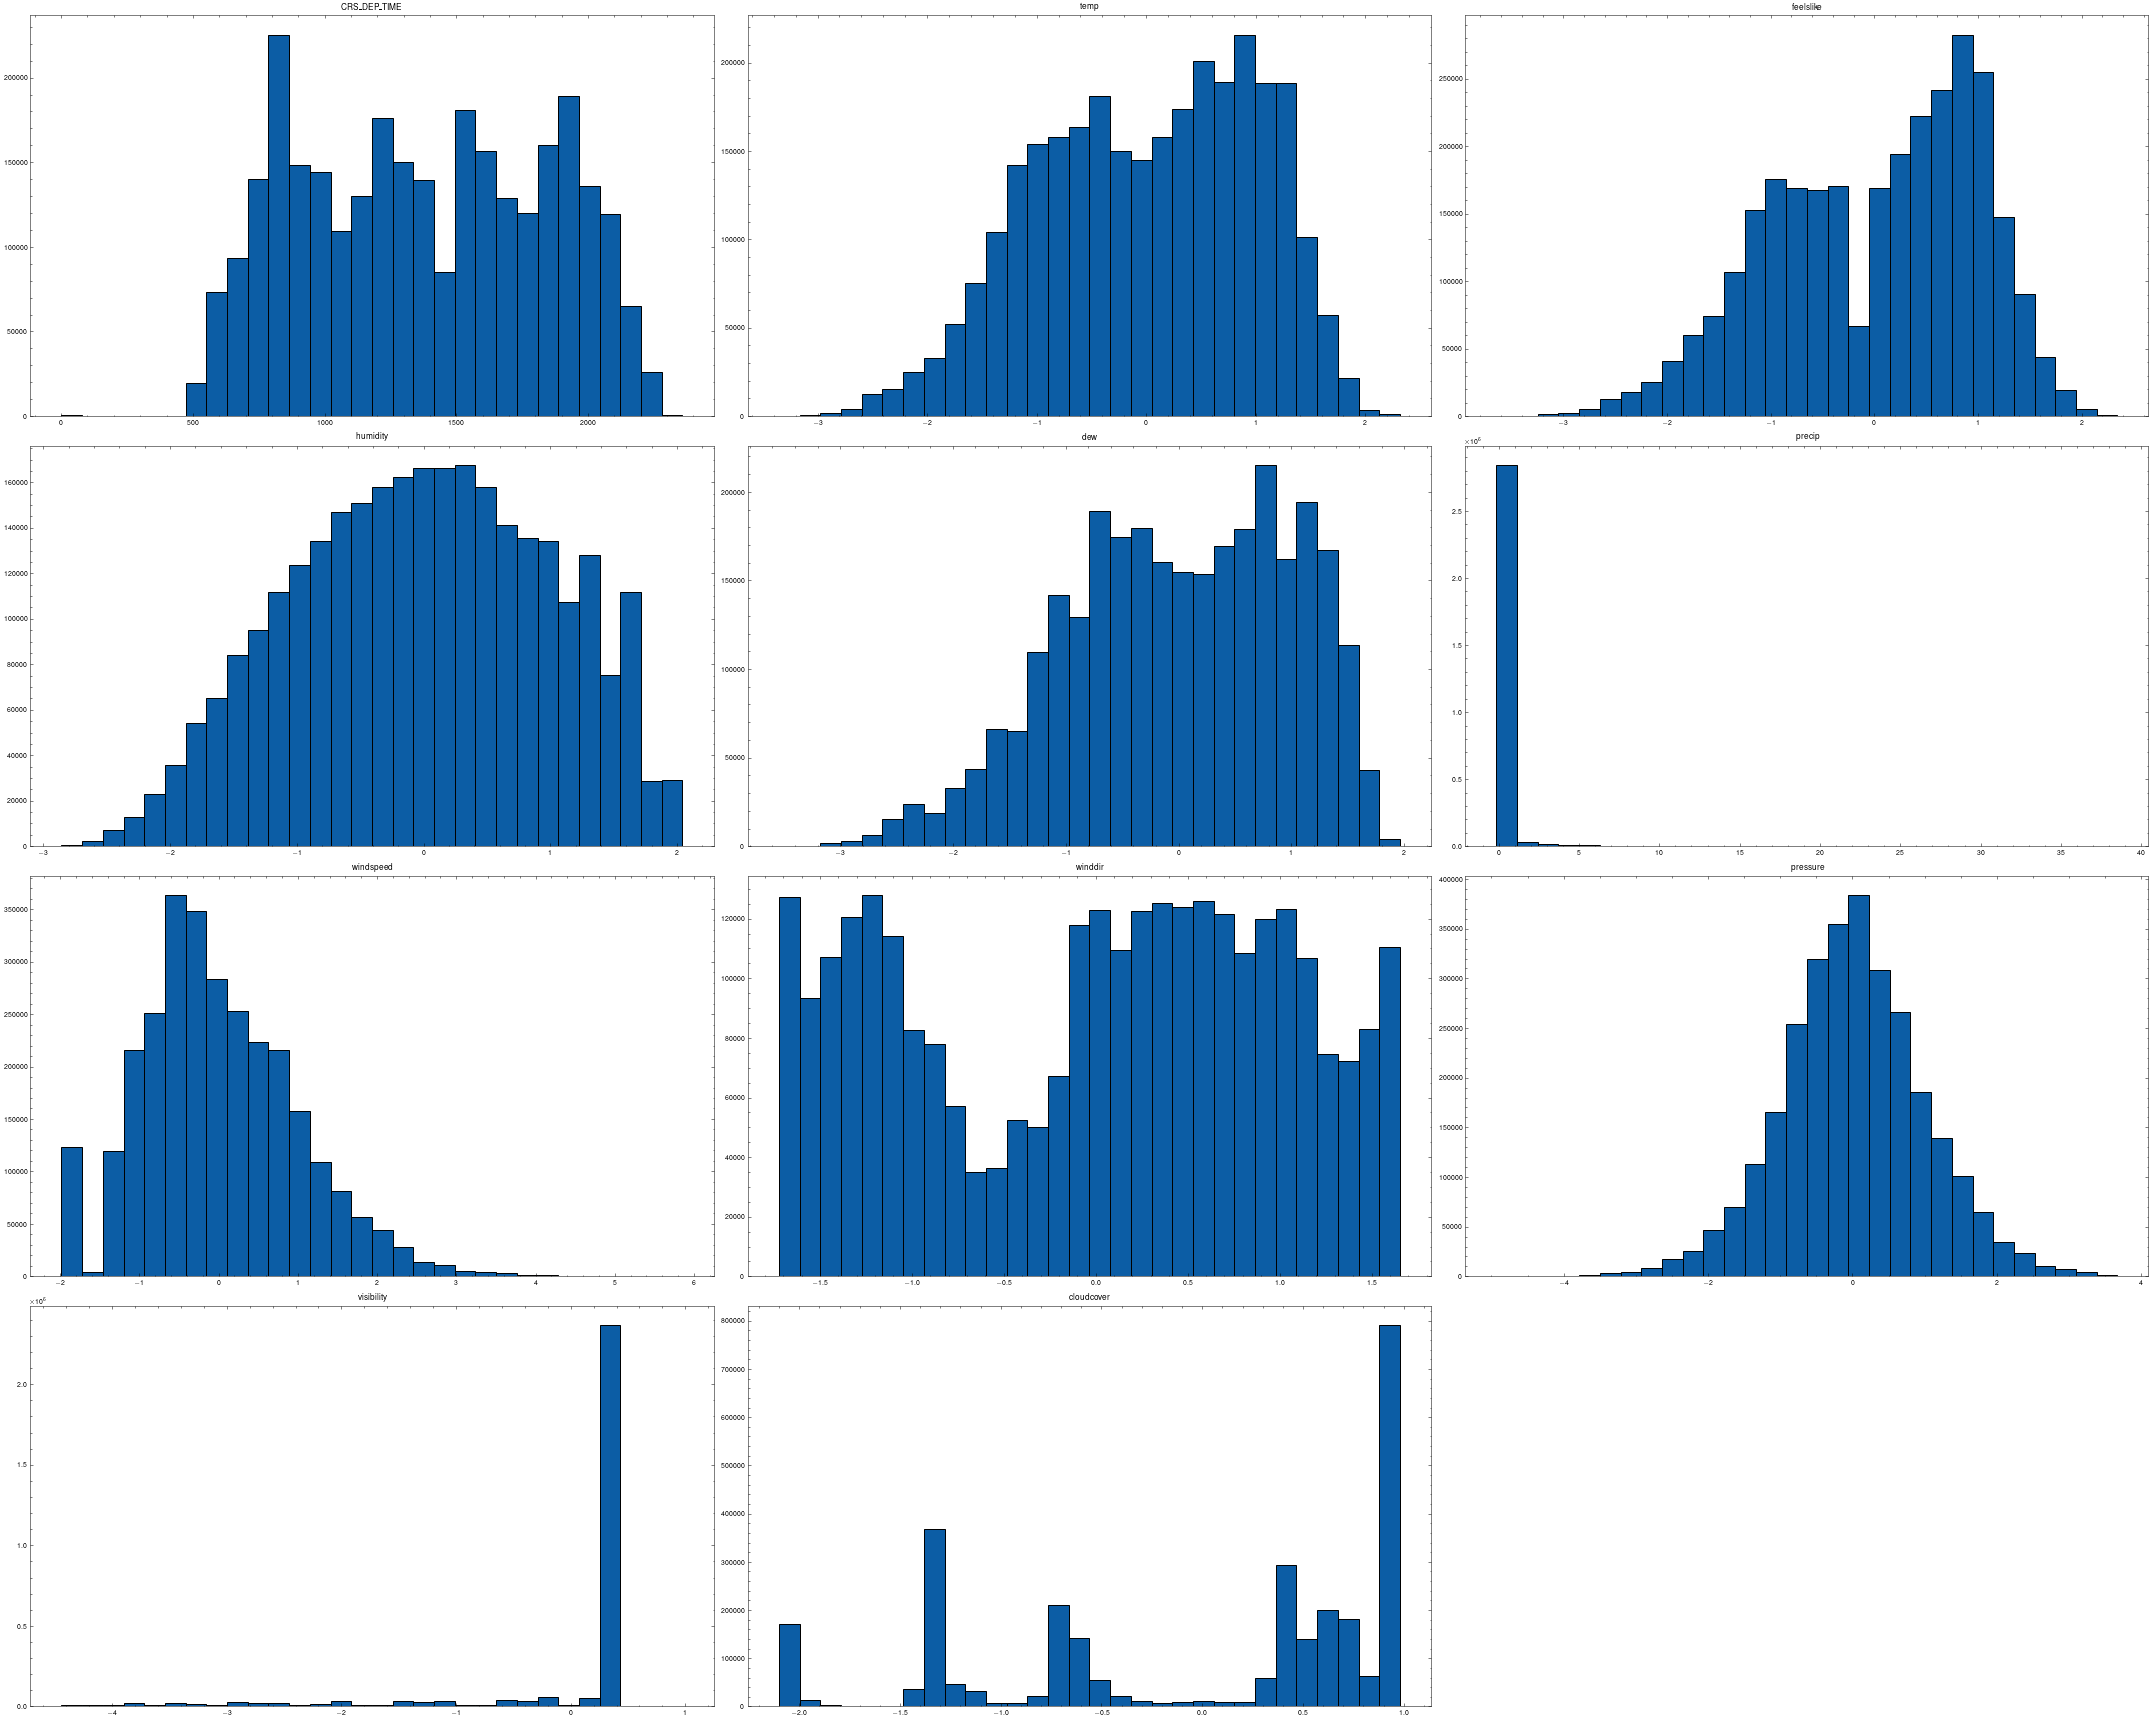

In [28]:
X.hist(column=['CRS_DEP_TIME', 'temp', 'feelslike', 'humidity', 'dew', 'precip', 'windspeed', 'winddir', 'pressure', 'visibility', 'cloudcover'], bins=30, grid=False, figsize=(30, 24), ec='k')
plt.tight_layout()
plt.show()


the precip looks like that because

In [29]:
X.precip.describe()

count    2.918098e+06
mean    -1.852492e-02
std      8.966934e-01
min     -1.479968e-01
25%     -1.479968e-01
50%     -1.479968e-01
75%     -1.479968e-01
max      3.852016e+01
Name: precip, dtype: float64

## Linear Regression

even though we are doing prediction analysis, we might as well start with inference for delay time with a linear regression.

transform categoricals to dummies

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

linear_regression_full = sm.OLS(Y_delay_time_train, X_train).fit()
linear_regression_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     613.7
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        16:39:30   Log-Likelihood:            -1.0318e+07
No. Observations:             2042668   AIC:                         2.064e+07
Df Residuals:                 2042386   BIC:                         2.064e+07
Df Model:                         281                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -19.6412      0.867    -22.662      0.000     -21.340     -17.942
C(OP_CARRIER)[T.AA]      -4.9889      0.607     -8.221      0.000      -6.178      -3.800
C(OP_CARRIER)[T.AS]     -10.7286      0.716    -14.984      0.000     -12.132      -9.325
C(OP_CARRIER)[T.B6]      -0.5395      0.676     -0.798      0.425      -1.865       0.786
C(OP_CARRIER)[T.CO]      -3.4763      0.711     -4.890      0.000      -4.870      -2.083
C(OP_CARRIER)[T.DL]      -2.0933      0.633     -3.309      0.001      -3.333      -0.853
C(OP_CARRIER)[T.EV]       2.4402      0.610      4.002      0.000       1.245       3.635
C(OP_CARRIER)[T.F9]       1.9949      0.712      2.803      0.005       0.600       3.390
C(OP_CARRIER)[T.MQ]      -3.6518      0.605     -6.038      0.000      -4.837      -2.466
C(OP_CARRIER)[T.NK]      -1.1096      0.649     -1.711      0.087      -2.381       0.162
C(OP_CARRIER)[T.NW]      -9.4715      0.874    -10.838      0.000     -11.184      -7.759
C(OP_CARRIER)[T.OH]       0.0821      0.794      0.103      0.918      -1.475       1.639
C(OP_CARRIER)[T.OO]      -0.3545      0.607     -0.584      0.559      -1.544       0.835
C(OP_CARRIER)[T.UA]      -2.7107      0.606     -4.473      0.000      -3.899      -1.523
C(OP_CARRIER)[T.US]      -8.5447      0.652    -13.102      0.000      -9.823      -7.266
C(OP_CARRIER)[T.VX]      -7.5556      0.765     -9.880      0.000      -9.054      -6.057
C(OP_CARRIER)[T.XE]      -0.1679      0.626     -0.268      0.788      -1.394       1.059
C(OP_CARRIER)[T.YV]      -0.3808      0.627     -0.607      0.544      -1.610       0.848
C(OP_CARRIER)[T.YX]      -6.2995      0.695     -9.070      0.000      -7.661      -4.938
C(DEST)[T.ABQ]            5.7347      0.750      7.645      0.000       4.264       7.205
C(DEST)[T.ACY]            6.3715      2.038      3.126      0.002       2.376      10.367
C(DEST)[T.AGS]           14.5237     18.912      0.768      0.443     -22.543      51.591
C(DEST)[T.ALB]            4.4123      0.652      6.770      0.000       3.135       5.690
C(DEST)[T.ALO]           -0.1595      0.907     -0.176      0.860      -1.936       1.617
C(DEST)[T.ANC]            6.6793      0.807      8.276      0.000       5.098       8.261
C(DEST)[T.ART]            2.3153      1.276      1.815      0.070      -0.186       4.816
C(DEST)[T.ASE]            8.9819      0.793     11.331      0.000       7.428      10.536
C(DEST)[T.ATL]            5.6593      0.538     10.513      0.000       4.604       6.714
C(DEST)[T.ATW]           -1.0835      0.620     -1.749      0.080      -2.298       0.131
C(DEST)[T.AUS]            4.4357      0.591      7.504      0.000       3.277       5.594
C(DEST)[T.AVL]            1.7492      0.722      2.423      0.015       0.334       3.164
C(DEST)[T.AVP]         

### Prediction

In [38]:
y_delay_time_predict = linear_regression_full.predict(X_test)
regression_results(Y_delay_time_test, y_delay_time_predict)

explained_variance:  0.0788
r2:  0.0788
MAE:  20.5443
MSE:  1414.141
RMSE:  37.6051


### Lasso Regression

In [39]:
from sklearn.linear_model import Lasso
linear_regression_full_LASSO = Lasso(random_state=42, fit_intercept=False)
linear_regression_full_LASSO.fit(X_train.to_numpy(), Y_delay_time_train.to_numpy())

Lasso(fit_intercept=False, random_state=42)

Lasso will select the most important features, and will set to 0 the others. Then we can see the ones that are important here

In [40]:
lasso_features = pd.DataFrame(linear_regression_full_LASSO.coef_, X_train.columns, columns=['coef']).sort_values(by='coef', ascending=False)
lasso_features[lasso_features['coef'] != 0]

,coef
precip,2.392249
feelslike:dew,2.087348
humidity,1.571559
feelslike:visibility,1.107713
cloudcover,0.866429
windspeed,0.630588
humidity:precip,0.331615
dew,0.033027
CRS_DEP_TIME,0.008028
dew:pressure,-0.059600


In [41]:
# predict for the test set
lasso_y_pred = linear_regression_full_LASSO.predict(X_test.to_numpy())
regression_results(Y_delay_time_test, lasso_y_pred)


explained_variance:  0.0542
r2:  0.054
MAE:  21.3125
MSE:  1452.0851
RMSE:  38.1062


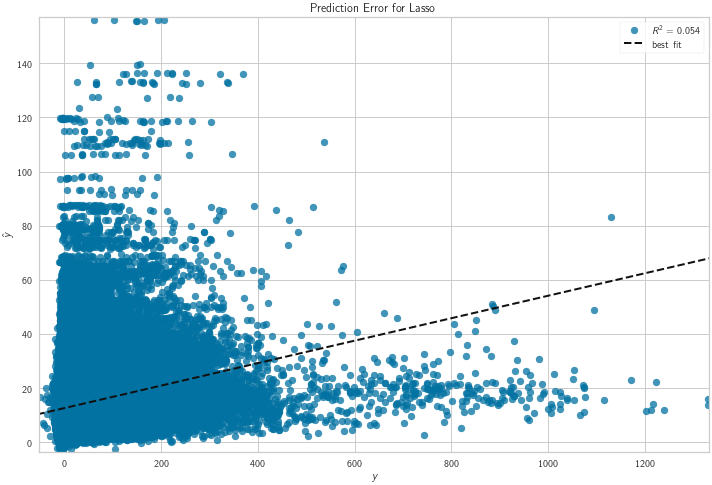

In [42]:
from yellowbrick.regressor import prediction_error
fig, ax = plt.subplots(figsize=(12, 8))
plt.ylim(0, 200)
visualizers = prediction_error(linear_regression_full_LASSO, X_train.to_numpy(), Y_delay_time_train.to_numpy(), X_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)


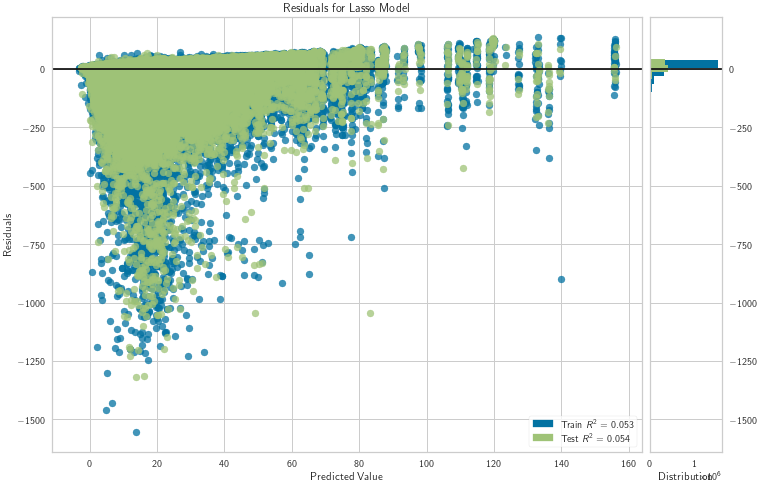

In [43]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(12, 8))
vis_rp = residuals_plot(linear_regression_full_LASSO, X_train.to_numpy(), Y_delay_time_train.to_numpy(), X_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

## AIC / BIC
### BIC

In [44]:
from sklearn.linear_model import LassoLarsIC

model_bic = LassoLarsIC(criterion='bic',  fit_intercept=False, verbose=100, normalize=False)
model_bic.fit(X_train.to_numpy(), Y_delay_time_train.to_numpy())

Step		Added		Dropped		Active set size		C
0		231				1		40133980922.0
1		275				2		16424365.474206991
2		240				3		8932443.787416559
3		234				4		8712635.871524796
4		260				5		6706398.80955848
5		252				6		6633365.57162626
6		241				7		5216378.963986396
7		239				8		4762678.964816807
8		257				9		4117980.5032907766
9		237				10		3536688.5610922957
10		236				11		3296541.887158116
11		269				12		2141902.6098885937
12		235				13		2092161.6357643544
13		261				14		1844029.5735111744
14		265				15		1797435.4794010152
15		254				16		1743807.105444732
16				[260]		15		[1674795.81579802]
17		8				16		1368329.9001338817
18		279				17		1320225.8359004331
19		266				18		1308232.3472254532
20		0				19		1102376.2476808412
21		211				20		1077666.2898407693
22		285				21		1051895.8553891513
23		209				22		984673.7279817284
24		230				23		811816.7904864666
25		244				24		699306.0422543511
26		278				25		692689.9788725724
27		219				26		678576.9508220647
28		259				27		649997.8359037032
29		216				28		

LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False, verbose=100)

In [45]:
bic_features = pd.DataFrame(model_bic.coef_, X_train.columns, columns=['coef'])
pd.set_option('display.max_rows', 300)
display(bic_features[bic_features['coef'] != 0])

,coef
Intercept,-14.903234
C(OP_CARRIER)[T.AA],-3.937753
C(OP_CARRIER)[T.AS],-9.336350
C(OP_CARRIER)[T.B6],0.095811
C(OP_CARRIER)[T.CO],-2.346628
C(OP_CARRIER)[T.DL],-1.280905
C(OP_CARRIER)[T.EV],2.723157
C(OP_CARRIER)[T.F9],3.167633
C(OP_CARRIER)[T.MQ],-3.209150
C(OP_CARRIER)[T.NW],-8.234768


In [46]:
# predict for the test set
bic_y_pred = model_bic.predict(X_test.to_numpy())
regression_results(Y_delay_time_test, bic_y_pred)

explained_variance:  0.0786
r2:  0.0786
MAE:  20.5447
MSE:  1414.3388
RMSE:  37.6077


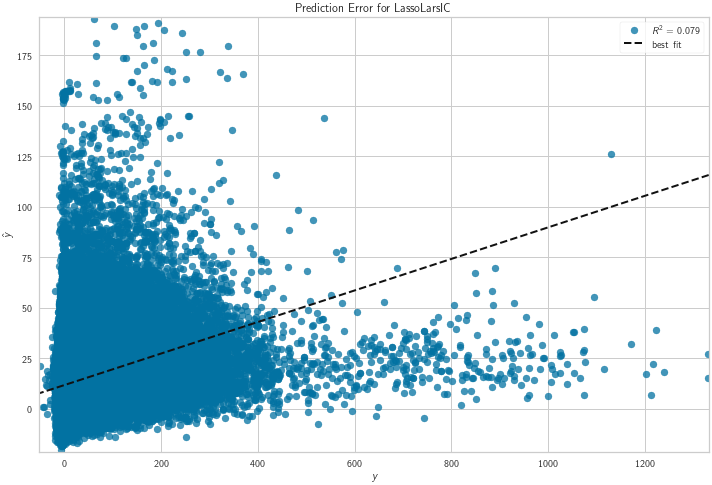

In [47]:
from yellowbrick.regressor import prediction_error
fig, ax = plt.subplots(figsize=(12, 8))
plt.ylim(0, 200)
visualizers = prediction_error(model_bic, X_train.to_numpy(), Y_delay_time_train.to_numpy(), X_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

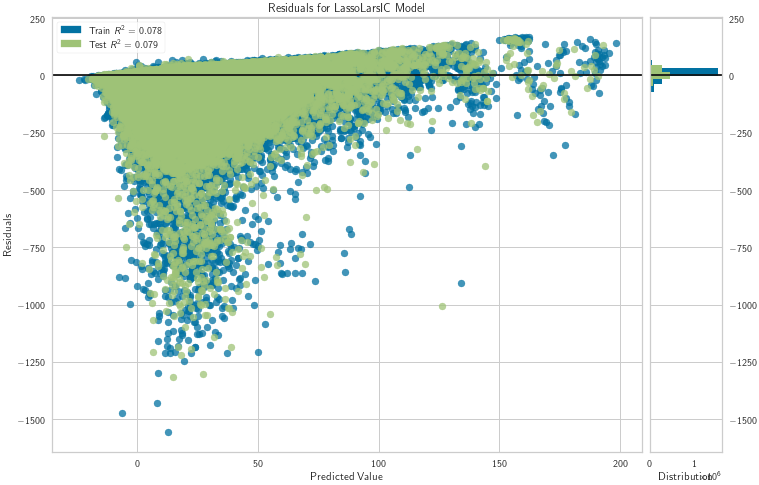

In [48]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(12, 8))
vis_rp = residuals_plot(model_bic, X_train.to_numpy(), Y_delay_time_train.to_numpy(), X_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

### AIC

In [49]:

from sklearn.linear_model import LassoLarsIC

model_aic = LassoLarsIC(criterion='aic',  fit_intercept=False, verbose=100, normalize=False)
model_aic.fit(X_train.to_numpy(), Y_delay_time_train.to_numpy())

Step		Added		Dropped		Active set size		C
0		231				1		40133980922.0
1		275				2		16424365.474206991
2		240				3		8932443.787416559
3		234				4		8712635.871524796
4		260				5		6706398.80955848
5		252				6		6633365.57162626
6		241				7		5216378.963986396
7		239				8		4762678.964816807
8		257				9		4117980.5032907766
9		237				10		3536688.5610922957
10		236				11		3296541.887158116
11		269				12		2141902.6098885937
12		235				13		2092161.6357643544
13		261				14		1844029.5735111744
14		265				15		1797435.4794010152
15		254				16		1743807.105444732
16				[260]		15		[1674795.81579802]
17		8				16		1368329.9001338817
18		279				17		1320225.8359004331
19		266				18		1308232.3472254532
20		0				19		1102376.2476808412
21		211				20		1077666.2898407693
22		285				21		1051895.8553891513
23		209				22		984673.7279817284
24		230				23		811816.7904864666
25		244				24		699306.0422543511
26		278				25		692689.9788725724
27		219				26		678576.9508220647
28		259				27		649997.8359037032
29		216				28		

LassoLarsIC(fit_intercept=False, normalize=False, verbose=100)

In [50]:
aic_features = pd.DataFrame(model_aic.coef_, X_train.columns, columns=['coef'])

display(aic_features[aic_features['coef'] != 0])

,coef
Intercept,-18.423771
C(OP_CARRIER)[T.AA],-4.750335
C(OP_CARRIER)[T.AS],-10.472829
C(OP_CARRIER)[T.B6],-0.317092
C(OP_CARRIER)[T.CO],-3.234644
C(OP_CARRIER)[T.DL],-1.872265
C(OP_CARRIER)[T.EV],2.624655
C(OP_CARRIER)[T.F9],2.240455
C(OP_CARRIER)[T.MQ],-3.448445
C(OP_CARRIER)[T.NK],-0.856662


In [51]:
# predict for the test set
aic_y_pred = model_aic.predict(X_test.to_numpy())

regression_results(Y_delay_time_test, aic_y_pred)

explained_variance:  0.0788
r2:  0.0788
MAE:  20.544
MSE:  1414.1252
RMSE:  37.6049


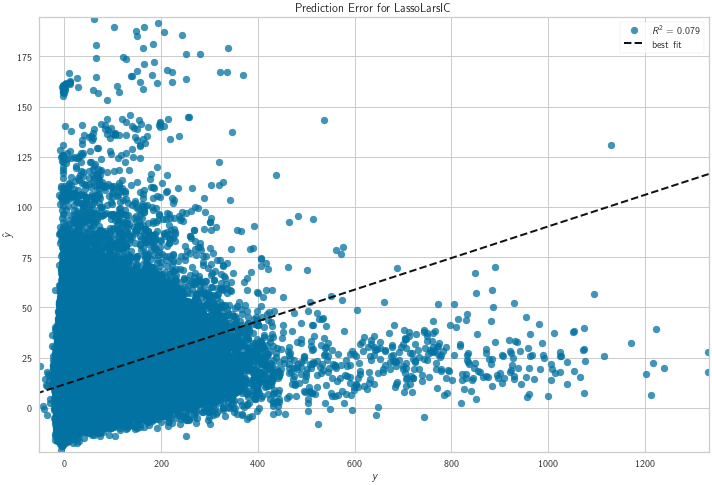

In [52]:
from yellowbrick.regressor import prediction_error
fig, ax = plt.subplots(figsize=(12, 8))
plt.ylim(0, 200)
visualizers = prediction_error(model_aic, X_train.to_numpy(), Y_delay_time_train.to_numpy(), X_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

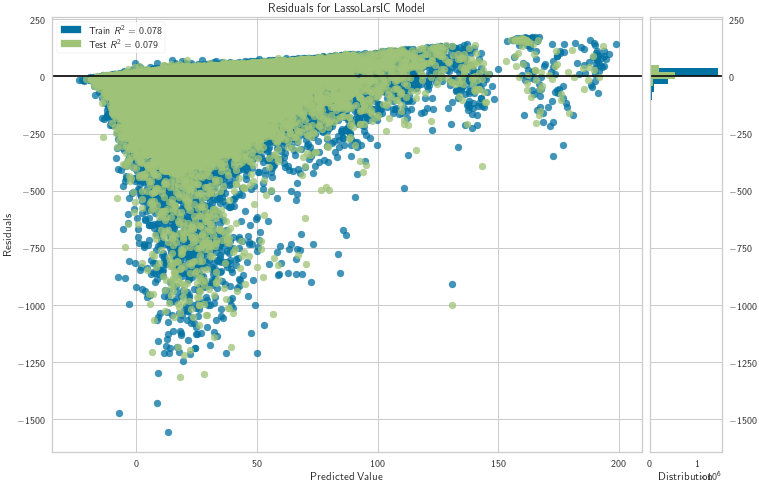

In [53]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(12, 8))
vis_rp = residuals_plot(model_aic, X_train.to_numpy(), Y_delay_time_train.to_numpy(), X_test.to_numpy(), Y_delay_time_test.to_numpy(), identity=False, ax=ax, shared_limits=False, is_fitted=True)

## Binary Logistic Regression Model for predict if airplane will be delayed or cancelled

We will output metrics as precision, recall, f1-score, etc! Put them on the report

### Any Delay

In [54]:
from sklearn.linear_model import LogisticRegression


logistic_any_delay = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga')
logistic_any_delay.fit(X_train.to_numpy(), Y_delayed_train.to_numpy())

/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(n_jobs=-1, penalty='l1', solver='saga')

In [55]:
y_logistic_any_delay_predict = logistic_any_delay.predict(X_test.to_numpy())
regression_results(Y_delayed_test, y_logistic_any_delay_predict)

explained_variance:  -0.3576
r2:  -0.4899
MAE:  0.3607
MSE:  0.3607
RMSE:  0.6006


Add this metrics! they look good!

In [63]:
from sklearn.metrics import classification_report
from yellowbrick.classifier import roc_auc, precision_recall_curve, confusion_matrix

print(classification_report(Y_delayed_test, y_logistic_any_delay_predict))

              precision    recall  f1-score   support

         0.0       0.65      0.85      0.73    515439
         1.0       0.61      0.34      0.44    359991

    accuracy                           0.64    875430
   macro avg       0.63      0.59      0.59    875430
weighted avg       0.63      0.64      0.61    875430



/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


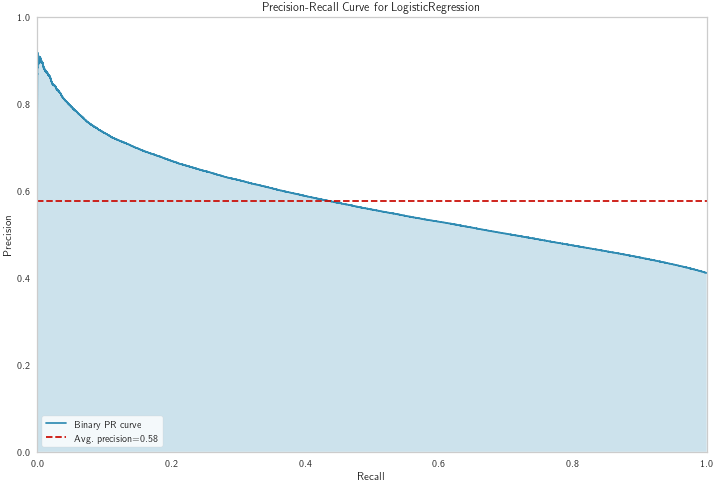

PrecisionRecallCurve(ax=<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>,
                     estimator=LogisticRegression(n_jobs=-1, penalty='l1',
                                                  solver='saga'),
                     iso_f1_values={0.2, 0.4, 0.6, 0.8})

In [70]:
fig = plt.figure(figsize=(12, 8))
precision_recall_curve(logistic_any_delay, X_train, Y_delayed_train, X_test, Y_delayed_test)


/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


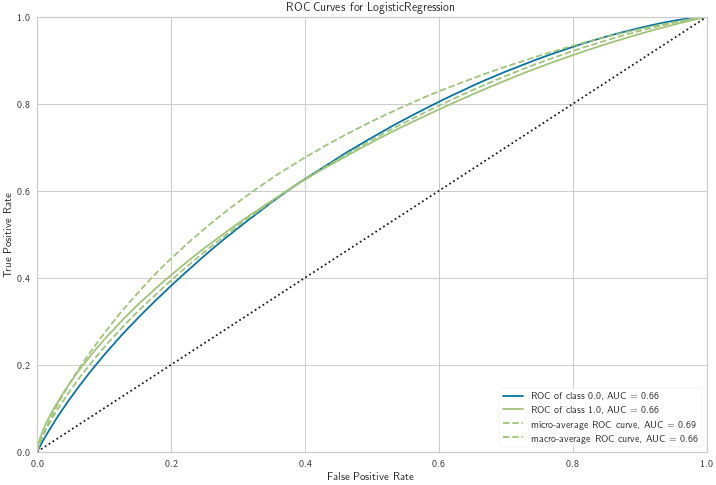

AttributeError: 'LogisticRegression' object has no attribute 'binary'

AttributeError: 'LogisticRegression' object has no attribute 'binary'

In [69]:
fig = plt.figure(figsize=(12, 8))
roc_auc(logistic_any_delay, X_train, Y_delayed_train, X_test, Y_delayed_test)

/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


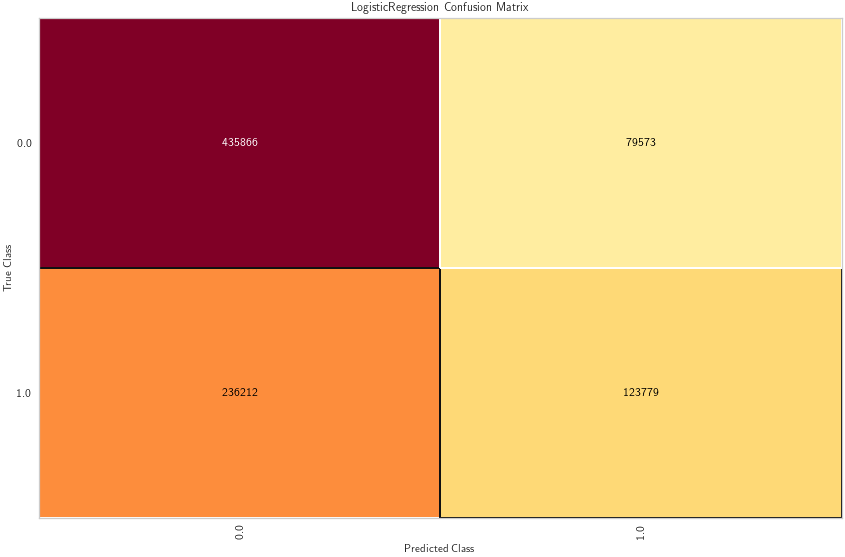

ConfusionMatrix(ax=<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                cmap=<matplotlib.colors.ListedColormap object at 0x3db371ba0>,
                estimator=LogisticRegression(n_jobs=-1, penalty='l1',
                                             solver='saga'))

In [71]:
fig = plt.figure(figsize=(12, 8))
confusion_matrix(logistic_any_delay, X_train, Y_delayed_train, X_test, Y_delayed_test)

### 20 min delay

In [74]:
logistic_20_delay = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga')
logistic_20_delay.fit(X_train.to_numpy(), Y_delayed_20_train.to_numpy())



In [ ]:

y_logistic_20_delay_predict = logistic_20_delay.predict(X_test.to_numpy())
regression_results(Y_delayed_20_test, y_logistic_20_delay_predict)


print(classification_report(Y_delayed_20_test, y_logistic_20_delay_predict))

explained_variance:  -0.0087
r2:  -0.2208
MAE:  0.1917
MSE:  0.1917
RMSE:  0.4379
              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89    704607
         1.0       0.63      0.04      0.08    170823

    accuracy                           0.81    875430
   macro avg       0.72      0.52      0.49    875430
weighted avg       0.78      0.81      0.73    875430



In [ ]:
fig = plt.figure(figsize=(12, 8))
precision_recall_curve(logistic_20_delay, X_train, Y_delayed_20_train, X_test, Y_delayed_20_test)

In [ ]:
fig = plt.figure(figsize=(12, 8))
roc_auc(logistic_20_delay, X_train, Y_delayed_20_train, X_test, Y_delayed_20_test)

In [ ]:
fig = plt.figure(figsize=(12, 8))
confusion_matrix(logistic_20_delay, X_train, Y_delayed_20_train, X_test, Y_delayed_20_test)

### Cancelled?

In [ ]:
logistic_cancelled_delay = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga')
logistic_cancelled_delay.fit(X_train.to_numpy(), Y_cancelled_train.to_numpy())

y_logistic_cancelled_predict = logistic_cancelled_delay.predict(X_test.to_numpy())
regression_results(Y_cancelled_test, y_logistic_cancelled_predict)

print(classification_report(Y_cancelled_test, y_logistic_cancelled_predict))

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(12, 8))
precision_recall_curve(logistic_cancelled_delay, X_train, Y_cancelled_train, X_test, Y_cancelled_test)

/Users/seba/miniforge3/envs/flight-predictions/lib/python3.10/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

<Figure size 864x576 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(12, 8))
roc_auc()(logistic_cancelled_delay, X_train, Y_cancelled_train, X_test, Y_cancelled_test)

In [ ]:
fig = plt.figure(figsize=(12, 8))
confusion_matrix()(logistic_cancelled_delay, X_train, Y_cancelled_train, X_test, Y_cancelled_test)

TypeError: confusion_matrix() missing 3 required positional arguments: 'estimator', 'X_train', and 'y_train'

<Figure size 864x576 with 0 Axes>